# Finding shift between two timeseries for maximum correlation

In [10]:
import strym
from strym import strymread
from scipy import signal


In [16]:
!pip list | grep scipy

scipy                              1.6.1
You should consider upgrading via the '/home/ivory/anaconda3/envs/dbn/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load the dataset

In [4]:
folder = "../PandaData/2021_02_11/"
s = strymread(csvfile=folder + "2021-02-11-19-58-29_2T3Y1RFV8KC014025_CAN_Messages.csv")

[2021_02_20_17_00_42] (numexpr.utils) INFO: NumExpr defaulting to 8 threads.


## We will using speed signal to demostrate time shift finding

In [5]:
can_speed = s.speed()

## Let's generate two timeseries, one is shifted with respected to other, but also add some noise (gamma noise) to one of the timeseries

In [6]:
df1 = can_speed.copy(deep=True)
df2 = can_speed.copy(deep=True)
df2['Time'] = df2['Time'] + 40.242212
df1['Message'] = df1['Message'] +np.random.gamma(0.2, 2.94, len(df1['Message']))

## Let's visualize these timeseries

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



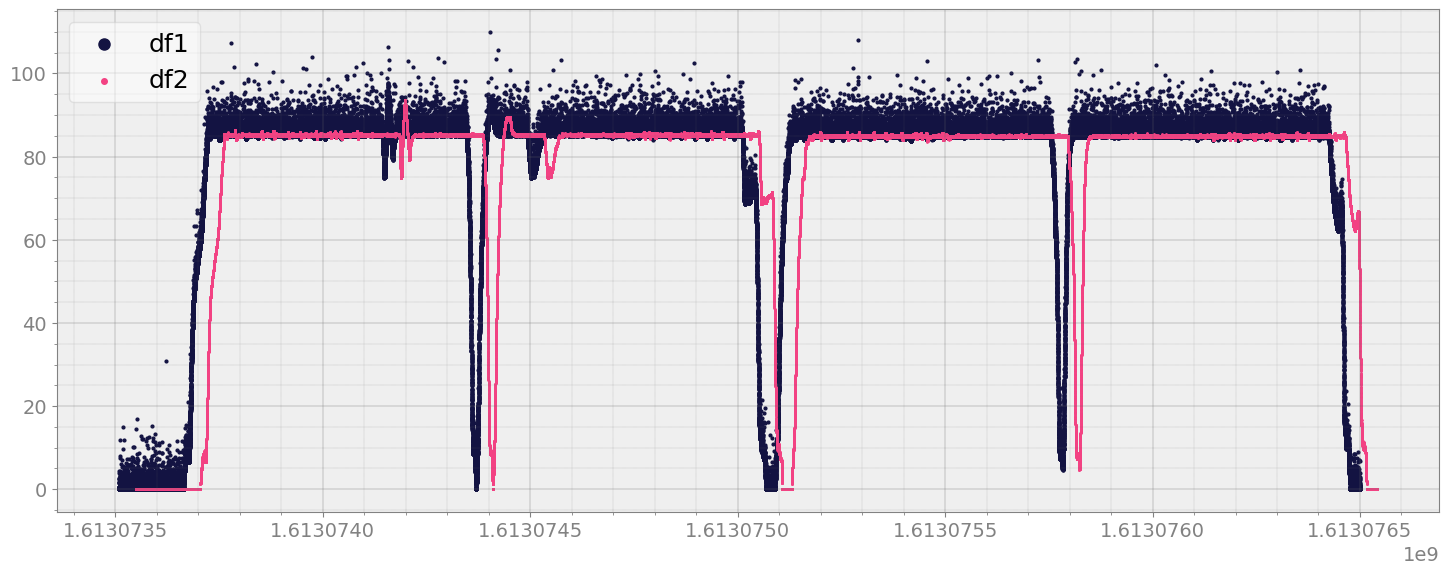

In [8]:
fig, ax = strymread.create_fig(1)
ax[0].scatter(x = df1['Time'], y = df1['Message'], s=4, label='df1', c= '#131342')
ax[0].scatter(x = df2['Time'], y = df2['Message'],  s=1, label = 'df2', c= '#f34283')
ax[0].legend()
fig.show()

## Now write `time_shift` function

In [15]:
def time_shift(df1, df2, time_col1 = 'Time', time_col2='Time', msg_col1 = 'Message', msg_col2= 'Message'):
    """
    Compute the time shift specified by `time_col2` of df2 with respect to 
    time of df1 specified by `time_col1`. Once you get time shift you will add it to 
    time axis of second dataframe
       
    
    """
    resample_time = np.max([np.median(np.diff(df1[time_col1])), np.median(np.diff(df1[time_col1]))])
    
    df1_re = strymread.resample(df1, rate = 1./resample_time, cont_method= 'nearest')
    df2_re = strymread.resample(df2, rate = 1./resample_time, cont_method= 'nearest')
    
    initial_time_gap = df1_re[time_col1][0] - df2_re[time_col2][0]
    
    x = df1_re[msg_col1].values
    y = df2_re[msg_col2].values

    correlation = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]
    
    lag_in_time_units = lag*resample_time
    
    total_time_shift = initial_time_gap + lag_in_time_units
    return total_time_shift
    

In [11]:
t_shift = time_shift(df1, df2)
t_shift

-40.24221205711365

**We can see that time shift is -40.24 seconds**

## Let's visualize after timeshift

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



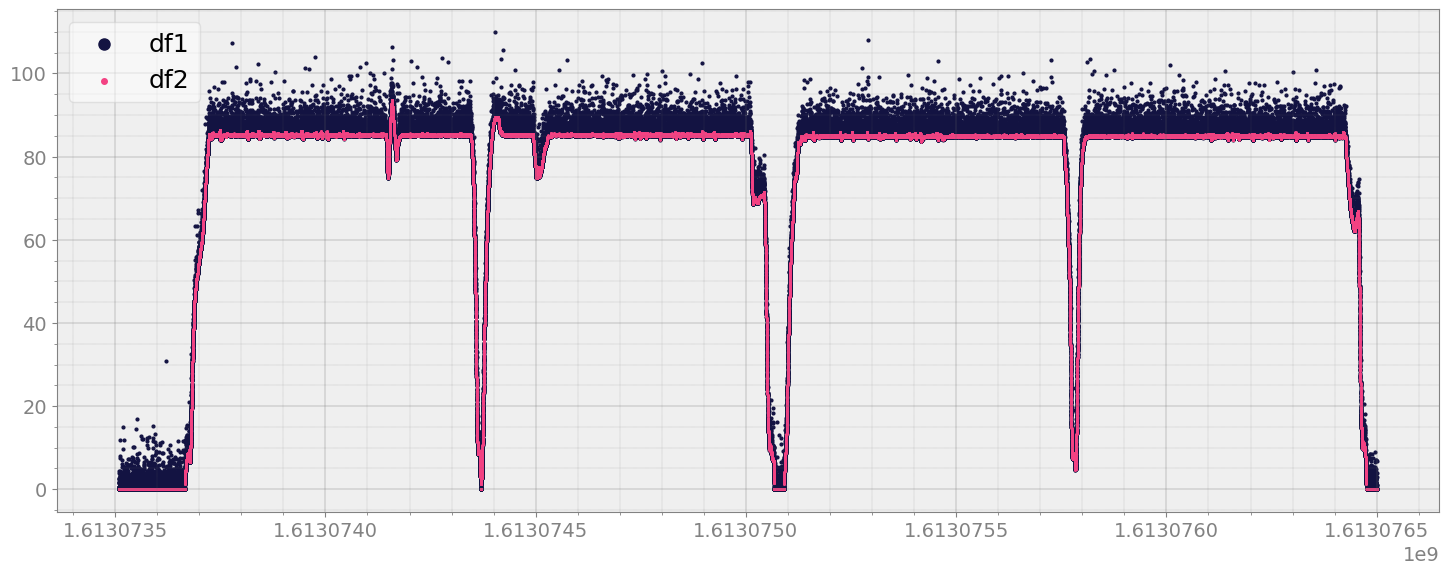

In [14]:
fig, ax = strymread.create_fig(1)
ax[0].scatter(x = df1['Time'], y = df1['Message'], s=4, label='df1', c= '#131342')
ax[0].scatter(x = df2['Time']+t_shift, y = df2['Message'],  s=1, label = 'df2', c= '#f34283')
ax[0].legend()
fig.show()

**As we can see, `time_shift` function determines correct time shift even in the presence of noise**